In [1]:
import os

import numpy as np
from pylab import *

import glob
import numba
from craft import calc11
from craco import metadatafile

from numba import jit,njit,prange
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
from craft.calc11 import uvw_ant_to_baselines


%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
m = metadatafile.MetadataFile('./data/SB43128/SB43128.json.gz')
fcm = './data/SB43128/r3702.fcm'

In [3]:
beam = 0
srcs = m.sources(beam)
src = srcs['B1934-638_beam0']
src

{'name': 'B1934-638_beam0',
 'ra': 294.8542750091011,
 'dec': -63.71266663279821,
 'epoch': 'J2000',
 'skycoord': <SkyCoord (ICRS): (ra, dec) in deg
     (294.85427501, -63.71266663)>,
 'scan_times': [[<Time object: scale='tai' format='mjd' value=59793.37236979184>,
   <Time object: scale='tai' format='mjd' value=59793.383083391825>]]}

In [4]:
src['skycoord']

<SkyCoord (ICRS): (ra, dec) in deg
    (294.85427501, -63.71266663)>

In [5]:
src['skycoord'].to_string('hmsdms')

'19h39m25.026s -63d42m45.5999s'

In [6]:
start = src['scan_times'][0][0]
start

<Time object: scale='tai' format='mjd' value=59793.37236979184>

In [7]:
start.datetime

datetime.datetime(2022, 8, 2, 8, 56, 12, 750015)

In [8]:
start.isot

'2022-08-02T08:56:12.750'

In [9]:
start.datetime.month

8

In [10]:
stop=src['scan_times'][0][1]

In [11]:
src

{'name': 'B1934-638_beam0',
 'ra': 294.8542750091011,
 'dec': -63.71266663279821,
 'epoch': 'J2000',
 'skycoord': <SkyCoord (ICRS): (ra, dec) in deg
     (294.85427501, -63.71266663)>,
 'scan_times': [[<Time object: scale='tai' format='mjd' value=59793.37236979184>,
   <Time object: scale='tai' format='mjd' value=59793.383083391825>]]}

In [12]:
#src = {'skycoord': SkyCoord(1.0835862116596362,-1.1475980042685163,unit='rad'), 'name': 'CRAFTSRC'}
#start = Time('2019-06-09T07:22:05')
#stop = start+0.01

In [13]:
from astropy.utils import iers
t = iers.earth_orientation_table.get()
toff = 3
tabentries = t[(start.mjd -toff < t['MJD'].value) & (t['MJD'].value < start.mjd+toff)]

In [14]:
iers.IERS_A_README

'/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/astropy/utils/iers/data/ReadMe.finals2000A'

In [15]:
tabentries

year,month,day,MJD,PolPMFlag_A,PM_x_A,e_PM_x_A,PM_y_A,e_PM_y_A,UT1Flag_A,UT1_UTC_A,e_UT1_UTC_A,LOD_A,e_LOD_A,NutFlag_A,dX_2000A_A,e_dX_2000A_A,dY_2000A_A,e_dY_2000A_A,PM_X_B,PM_Y_B,UT1_UTC_B,dX_2000A_B,dY_2000A_B,UT1_UTC,UT1Flag,PM_x,PM_y,PolPMFlag,dX_2000A,dY_2000A,NutFlag
,,,d,,arcsec,arcsec,arcsec,arcsec,,s,s,ms,ms,,marcsec,marcsec,marcsec,marcsec,arcsec,arcsec,s,marcsec,marcsec,s,,arcsec,arcsec,,marcsec,marcsec,
int64,int64,int64,float64,str1,float64,float64,float64,float64,str1,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,str1,float64,float64,str1
22,7,31,59791.0,I,0.285988,3.4e-05,0.407304,4.2e-05,I,-0.0381715,1.55e-05,-0.9227,0.0114,I,0.344,0.317,-0.277,0.318,0.286,0.407286,-0.0381849,0.267,-0.233,-0.0381849,B,0.286,0.407286,B,0.267,-0.233,B
22,8,1,59792.0,I,0.28713,3.5e-05,0.405166,4.1e-05,I,-0.0373374,1.55e-05,-0.7092,0.0098,I,0.342,0.317,-0.283,0.318,0.287161,0.405194,-0.0373892,0.268,-0.276,-0.0373892,B,0.287161,0.405194,B,0.268,-0.276,B
22,8,2,59793.0,I,0.287882,2.9e-05,0.403331,3.1e-05,I,-0.0367455,1.2e-05,-0.5186,0.0097,I,0.337,0.303,-0.285,0.284,0.287882,0.403262,-0.0367846,0.268,-0.319,-0.0367846,B,0.287882,0.403262,B,0.268,-0.319,B
22,8,3,59794.0,I,0.288546,2.9e-05,0.40095,3.1e-05,I,-0.0362586,1.17e-05,-0.453,0.0081,I,0.331,0.303,-0.283,0.284,0.288468,0.401019,-0.0362792,0.267,-0.295,-0.0362792,B,0.288468,0.401019,B,0.267,-0.295,B
22,8,4,59795.0,I,0.289526,3e-05,0.398758,3.1e-05,I,-0.0358142,1.09e-05,-0.4635,0.0079,I,0.322,0.303,-0.278,0.284,0.289489,0.398709,-0.0358145,0.265,-0.254,-0.0358145,B,0.289489,0.398709,B,0.265,-0.254,B
22,8,5,59796.0,I,0.290536,2.9e-05,0.396538,3e-05,I,-0.0353134,1.06e-05,-0.5287,0.0066,I,0.31,0.303,-0.273,0.284,0.290582,0.396579,-0.0353263,0.267,-0.247,-0.0353263,B,0.290582,0.396579,B,0.267,-0.247,B


In [16]:
m.times[0].isot

'2022-08-02T08:56:12.750'

In [17]:
src['name']

'B1934-638_beam0'

In [19]:

# create calcfile from src, skycoord
cf = calc11.CalcFile.from_time_src(start,stop,src['skycoord'],src['name'])

# auto automagic eops from astropy
cf.add_eops()

# add antenna data from FCM

# load FCM antenna data
from craft import fcm2calc
antd, antnos = fcm2calc.load_parset(fcm, prefix='common.antenna.ant')
cf.add_antdata(antd, antnos)


In [20]:
print(str(cf))

JOB ID:             374055
JOB START TIME:     59793.3719415511
JOB STOP TIME:      59793.38265515109
DUTY CYCLE:         1.000
OBSCODE:            CRAFTFR
DIFX VERSION:       trunk
SUBJOB ID:          0
SUBARRAY ID:        0
VEX FILE:           /fred/oz002/adeller/askap/frb190608/0407/data/c1_f0/craftfrb.vex
START MJD:          59793.3719415511
START YEAR:         2022
START MONTH:        8
START DAY:          2
START HOUR:         8
START MINUTE:       55
START SECOND:       35
SPECTRAL AVG:       1
TAPER FUNCTION:     UNIFORM
NUM SOURCES:        1
SOURCE 0 NAME:      B1934-638_beam0
SOURCE 0 RA:        5.146177912489648
SOURCE 0 DEC:       -1.1119958079678578
SOURCE 0 CALCODE:   
SOURCE 0 QUAL:      0
NUM SCANS:          1
SCAN 0 IDENTIFIER:  No0001
SCAN 0 START (S):   0
SCAN 0 DUR (S):     925
SCAN 0 OBS MODE NAME:askap
SCAN 0 UVSHIFT INTERVAL (NS):2000000000
SCAN 0 AC AVG INTERVAL (NS):2000000
SCAN 0 POINTING SRC:0
SCAN 0 NUM PHS CTRS:1
SCAN 0 PHS CTR 0:   0
NUM SPACECRAFT:     0


In [21]:
# run calc and parse results
rf = calc11.run_calc(cf, 'my.calc')
!cat my.im

CALC SERVER:        NONE
CALC PROGRAM:       DIFXCALC
CALC VERSION:       11
START YEAR:         2022
START MONTH:        8
START DAY:          2
START HOUR:         8
START MINUTE:       55
START SECOND:       35
POLYNOMIAL ORDER:   5
INTERVAL (SECS):    120
ABERRATION CORR:    EXACT
NUM TELESCOPES:     36
TELESCOPE 0 NAME:   ak01
TELESCOPE 1 NAME:   ak02
TELESCOPE 2 NAME:   ak03
TELESCOPE 3 NAME:   ak04
TELESCOPE 4 NAME:   ak05
TELESCOPE 5 NAME:   ak06
TELESCOPE 6 NAME:   ak07
TELESCOPE 7 NAME:   ak08
TELESCOPE 8 NAME:   ak09
TELESCOPE 9 NAME:   ak10
TELESCOPE 10 NAME:  ak11
TELESCOPE 11 NAME:  ak12
TELESCOPE 12 NAME:  ak13
TELESCOPE 13 NAME:  ak14
TELESCOPE 14 NAME:  ak15
TELESCOPE 15 NAME:  ak16
TELESCOPE 16 NAME:  ak17
TELESCOPE 17 NAME:  ak18
TELESCOPE 18 NAME:  ak19
TELESCOPE 19 NAME:  ak20
TELESCOPE 20 NAME:  ak21
TELESCOPE 21 NAME:  ak22
TELESCOPE 22 NAME:  ak23
TELESCOPE 23 NAME:  ak24
TELESCOPE 24 NAME:  ak25
TELESCOPE 25 NAME:  ak26
TELESCOPE 26 NAME:  ak27
TELESCOPE 27 NAM

SRC 1 ANT 2 AZ:      1.512092727881892e+02	-4.910549664547999e-04	 5.726777199991358e-08	 8.979599453329961e-13	 2.057041405594456e-17	 3.301610615186207e-21
SRC 1 ANT 2 EL GEOM: 2.296252169928306e+01	 1.797690518092146e-03	 1.401817105916326e-08	-1.112172936492609e-12	-6.126111037133865e-18	-1.070392900231646e-20
SRC 1 ANT 2 U (m):   5.706295879798595e+06	 1.138522127939314e+01	-1.515568386740951e-02	-1.155246620143657e-08	 2.187980323120894e-11	-5.442718147231204e-14
SRC 1 ANT 2 V (m):   1.398516566800095e+06	-3.725418221934063e+02	-3.580235572700177e-04	 3.294325466745923e-07	 1.012253848369446e-11	-4.081730326389529e-14
SRC 1 ANT 2 W (m):  -2.472913805706805e+06	-1.843964271310054e+02	-2.121913830819722e-04	 1.634473349291191e-07	-2.039076068487904e-13	 1.010691228925455e-15
SRC 1 ANT 3 DELAY (us): 8.248611881457964e+03	 6.150814641713922e-01	 7.079721693312477e-07	-5.452018706764973e-10	 6.733956670742818e-16	-3.350298219578020e-18
SRC 1 ANT 3 DRY (us): 1.879158737447214e-02	-1.36

In [22]:
rf

ResultsFile([('CALC SERVER', 'NONE'),
             ('CALC PROGRAM', 'DIFXCALC'),
             ('CALC VERSION', '11'),
             ('START YEAR', '2022'),
             ('START MONTH', '8'),
             ('START DAY', '2'),
             ('START HOUR', '8'),
             ('START MINUTE', '55'),
             ('START SECOND', '35'),
             ('POLYNOMIAL ORDER', '5'),
             ('INTERVAL (SECS)', '120'),
             ('ABERRATION CORR', 'EXACT'),
             ('NUM TELESCOPES', '36'),
             ('TELESCOPE 0 NAME', 'ak01'),
             ('TELESCOPE 1 NAME', 'ak02'),
             ('TELESCOPE 2 NAME', 'ak03'),
             ('TELESCOPE 3 NAME', 'ak04'),
             ('TELESCOPE 4 NAME', 'ak05'),
             ('TELESCOPE 5 NAME', 'ak06'),
             ('TELESCOPE 6 NAME', 'ak07'),
             ('TELESCOPE 7 NAME', 'ak08'),
             ('TELESCOPE 8 NAME', 'ak09'),
             ('TELESCOPE 9 NAME', 'ak10'),
             ('TELESCOPE 10 NAME', 'ak11'),
             ('TELESCOPE 11 NAME

In [23]:
mjds = m.times[30:].utc
mjds

<Time object: scale='utc' format='mjd' value=[59793.37539755 59793.37551275 59793.37562795 59793.37574315
 59793.37585835 59793.37597355 59793.37608875 59793.37620395
 59793.37631915 59793.37643435 59793.37654955 59793.37666475
 59793.37677995 59793.37689515 59793.37701035 59793.37712555
 59793.37724075 59793.37735595 59793.37747115 59793.37758635
 59793.37770155 59793.37781675 59793.37793195 59793.37804715
 59793.37816235 59793.37827755 59793.37839275 59793.37850795
 59793.37862315 59793.37873835 59793.37885355 59793.37896875
 59793.37908395 59793.37919915 59793.37931435 59793.37942955
 59793.37954475 59793.37965995 59793.37977515 59793.37989035
 59793.38000555 59793.38012075 59793.38023595 59793.38035115
 59793.38046635 59793.38058155 59793.38069675 59793.38081195
 59793.38092715 59793.38104235 59793.38115755 59793.38127275
 59793.38138795 59793.38150315 59793.38161835 59793.38173355
 59793.38184875 59793.38196395 59793.38207915 59793.38219435
 59793.38230955 59793.38242475 59793.382

In [24]:
polyvals = [rf.scans[0].eval_src0_poly(m) for m in mjds.utc.value]

In [25]:
m.all_uvw.shape

(94, 36, 36, 3)

In [26]:
meta_uvws = m.all_uvw[20:30,:,beam,:]

In [27]:
meta_uvws[0,0,:] # ak01 UVW from telescope

array([-5701092.93385472, -1510315.5674455 ,  2418091.67000994])

In [28]:
p0 = polyvals[0]
p0['ak01'] # ak01 UVW from dixcalc11

{'DELAY (us)': 8122.262502214757,
 'DRY (us)': 0.0190759889008613,
 'WET (us)': 0.0008653188231081585,
 'AZ': 151.3127044541654,
 'EL GEOM': 22.593329759438127,
 'U (m)': 5703309.294065901,
 'V (m)': 1475147.5388398455,
 'W (m)': -2434993.040060193}

In [29]:
meta_uvws_fit = m.uvw_at_time(mjds.tai.value)[:,:,beam,:]
meta_uvws_fit.shape

(64, 36, 3)

In [149]:
from astropy.table import QTable
metadata_time_offset = +5/3600/24 # looks like the metadata timestamps are about 5 seconds
d = rf.scans[0].eval_src0_poly_table(mjds + metadata_time_offset)
d['delay'].shape

(36, 64)

In [132]:
d1 = d[d['antennas'] == 'ak01'][0]
d1

antennas,delay [64],dry [64],wet [64],az [64],el [64],u [64],v [64],w [64]
,us,us,us,deg,deg,m,m,m
str4,float64,float64,float64,float64,float64,float64,float64,float64
ak01,8125.336125814054 .. 8511.07957000921,0.019068939922692305 .. 0.018223519281560675,0.0008649959418860627 .. 0.0008262956989268652,151.31013333524572 .. 151.01039131121075,22.602289032741957 .. 23.731430096236856,5703397.014986346 .. 5708391.733520182,1473285.7628705609 .. 1239658.6652151116,-2435914.489233993 .. -2551557.464526644


In [133]:
d1['delay'].shape

(64,)

(64, 36, 3) (64, 36, 3)


<IPython.core.display.Javascript object>


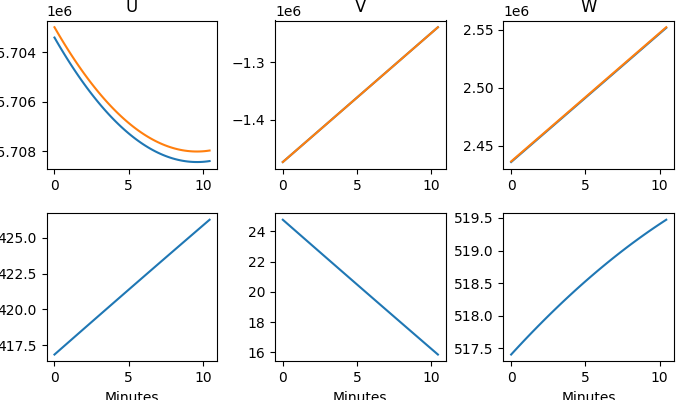

In [134]:

az = d['az']
el = d['el']
uvw = np.array([d['u'],d['v'],d['w']]).transpose(2,1,0)

print(meta_uvws_fit.shape, uvw.shape)


t = (mjds.tai.value - mjds[0].tai.value)*24*60
fig,ax = subplots(2,3)
fig.set_size_inches(7,4)
fig.tight_layout()
for i, lbl in enumerate('UVW'):
    ax[0,i].set_title(lbl)
    ax[0,i].plot(t, -uvw[:, 0,i])
    ax[0,i].plot(t, meta_uvws_fit[:,0,i])
    ax[1,i].plot(t, meta_uvws_fit[:,0,i]+uvw[:,0,i])
    ax[1,0].set_ylabel('Error')
    ax[1,i].set_xlabel('Minutes')


In [136]:
uvw.shape

(64, 36, 3)

In [137]:
meta_uvws_fit.shape

(64, 36, 3)

In [138]:
meta_uvws_fit_t = meta_uvws_fit.transpose(1,0,2)
meta_uvws_fit_t.shape

(36, 64, 3)

In [139]:
meta_bl_uvws = uvw_ant_to_baselines(meta_uvws_fit_t)
calc_bl_uvws = uvw_ant_to_baselines(uvw.transpose(1,0,2))

In [140]:
meta_bl_uvws.shape

(630, 64, 3)

In [141]:
calc_bl_uvws[ibl, :, i]


array([-912.00300552, -912.06687454, -912.13017891, -912.19291861,
       -912.2550936 , -912.31670385, -912.37774933, -912.43823   ,
       -912.49814584, -912.55749681, -912.61628289, -912.67450402,
       -912.73216021, -912.78925139, -912.84577756, -912.90173867,
       -912.9571347 , -913.01196563, -913.06623141, -913.11993203,
       -913.17306744, -913.22563764, -913.27764259, -913.32908225,
       -913.37995661, -913.43026564, -913.4800093 , -913.52918759,
       -913.57780046, -913.62584789, -913.67332987, -913.72024635,
       -913.76659732, -913.81238276, -913.85760264, -913.90225692,
       -913.9463456 , -913.98986865, -914.03282605, -914.07521777,
       -914.11704379, -914.15830408, -914.19899864, -914.23912743,
       -914.27869044, -914.31768764, -914.35611901, -914.39398453,
       -914.43128419, -914.46801796, -914.50418583, -914.53978777,
       -914.57482377, -914.6092938 , -914.64319785, -914.6765359 ,
       -914.70930794, -914.74151394, -914.7731539 , -914.80422

<IPython.core.display.Javascript object>


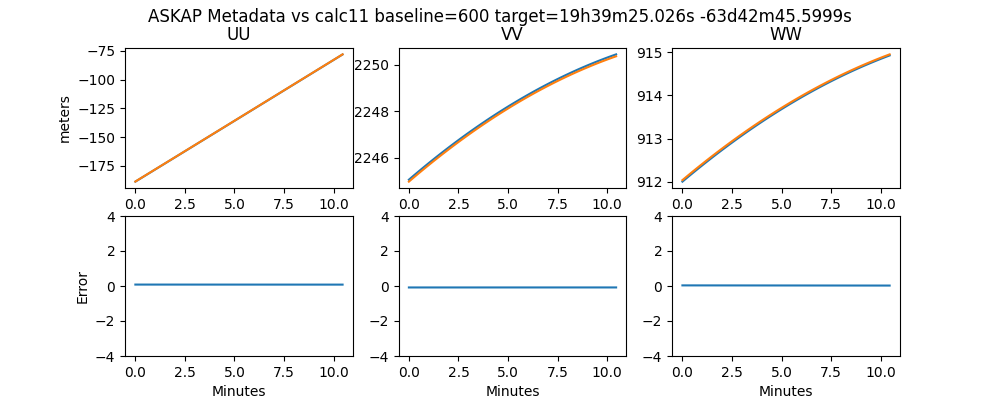

In [142]:
ibl = 600
fig,ax = subplots(2,3)
fig.set_size_inches(10,4)
fig.suptitle(f'ASKAP Metadata vs calc11 baseline={ibl} target={src["skycoord"].to_string("hmsdms")}')
#fig.tight_layout()

for i, lbl in enumerate(('UU','VV','WW')):
    ax[0,i].set_title(lbl)
    ax[0,i].plot(t, -calc_bl_uvws[ibl, :, i])
    ax[0,i].plot(t, meta_bl_uvws[ibl,:,i])
    ax[1,i].plot(t, meta_bl_uvws[ibl,:,i].T+calc_bl_uvws[ibl,:,i].T)
    ax[1,0].set_ylabel('Error')
    ax[1,i].set_xlabel('Minutes')
    ax[1,i].set_ylim(-4,4)
    ax[0,0].set_ylabel('meters')
    

<IPython.core.display.Javascript object>


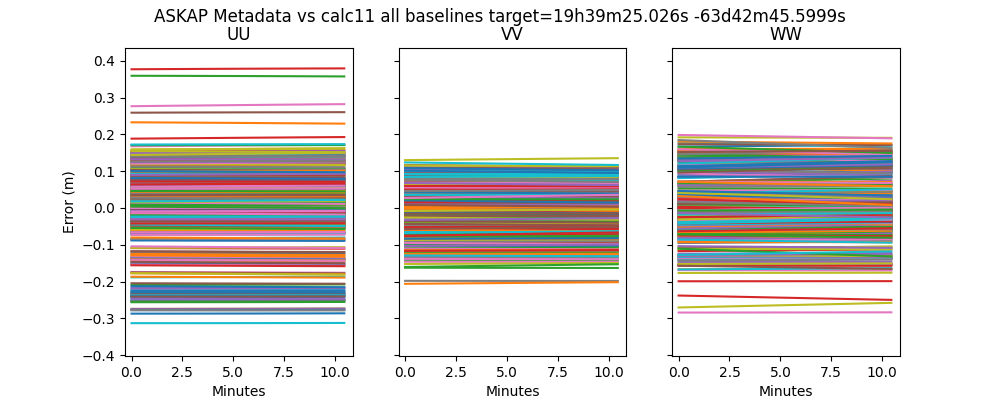

In [148]:
fig,ax = subplots(1,3, sharex=True,sharey=True)
fig.set_size_inches(10,4)
fig.suptitle(f'ASKAP Metadata vs calc11 all baselines target={src["skycoord"].to_string("hmsdms")}')
#fig.tight_layout()

for i, lbl in enumerate(('UU','VV','WW')):
    ax[i].plot(t, meta_bl_uvws[:,:,i].T+calc_bl_uvws[:,:,i].T)
    ax[0].set_ylabel('Error (m)')
    ax[i].set_xlabel('Minutes')
    ax[i].set_ylim(-1,1)
    ax[i].set_title(lbl)
    

<IPython.core.display.Javascript object>


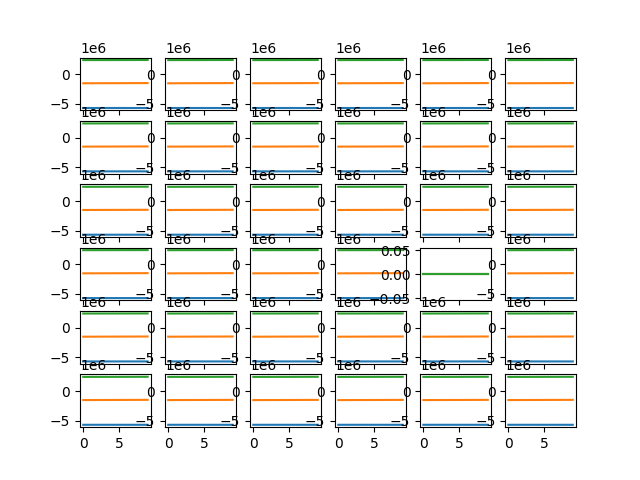

In [145]:
fig,ax = subplots(6,6)
ax = ax.flatten()
for iant in range(36):
    ax[iant].plot(meta_uvws[:,iant,:])
    

In [41]:
m.all_azel.shape

(94, 36, 2)

In [42]:
myskycoord = SkyCoord(294.85427501, -63.71266663, unit='deg')
myskycoord


<SkyCoord (ICRS): (ra, dec) in deg
    (294.85427501, -63.71266663)>

In [43]:
mytime = Time(59793.37236979184, scale='tai', format='mjd')
mytime

<Time object: scale='tai' format='mjd' value=59793.37236979184>

In [44]:
mytime = Time(59793.37236979184, scale='tai', format='mjd')
myskycoord = SkyCoord(294.85427501, -63.71266663, unit='deg')

askap = EarthLocation.of_site('ASKAP')
askap
altaz = src['skycoord'].transform_to(AltAz(obstime=m.times,location=askap))

In [45]:
az.shape

(36, 64)

<IPython.core.display.Javascript object>


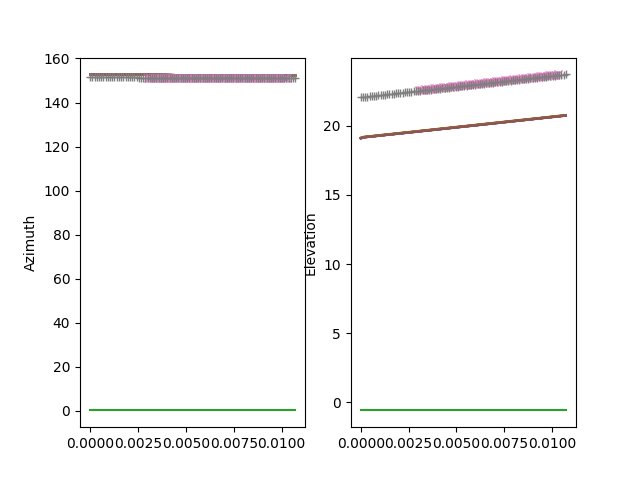

Text(0, 0.5, 'Elevation')

In [46]:
fig,ax = subplots(1,2)
t0 = m.time_floats[0]
ax[0].plot(m.time_floats - t0, m.all_azel[:,:,0])
ax[0].plot(mjds.value- t0, az[0,:], 'x')
ax[0].plot(m.time_floats - t0, altaz.az.value,'+')


ax[1].plot(m.time_floats- t0, m.all_azel[:,:,1])
ax[1].plot(mjds.value- t0, el[0,:], 'x')
ax[1].plot(m.time_floats - t0, altaz.alt.value,'+')
ax[0].set_ylabel('Azimuth')
ax[1].set_ylabel('Elevation')

In [47]:
m.sources(0)

OrderedDict([('B1934-638_beam0',
              {'name': 'B1934-638_beam0',
               'ra': 294.8542750091011,
               'dec': -63.71266663279821,
               'epoch': 'J2000',
               'skycoord': <SkyCoord (ICRS): (ra, dec) in deg
                   (294.85427501, -63.71266663)>,
               'scan_times': [[<Time object: scale='tai' format='mjd' value=59793.37236979184>,
                 <Time object: scale='tai' format='mjd' value=59793.383083391825>]]})])

In [48]:
(m.times[-1]-m.times[0])*60*24

<TimeDelta object: scale='tai' format='jd' value=15.427583979908377>

In [49]:
d0 = m.d0

In [50]:
d0.keys()

dict_keys(['antenna_targets', 'antennas', 'beams_direction', 'beams_offsets', 'cycle_period', 'flagged', 'phase_direction', 'polangle', 'polmode', 'sbid', 'scan_id', 'schedulingblock_id', 'sky_frequency', 'target_direction', 'target_name', 'timestamp'])

In [51]:
d0['timestamp']

5166147372750014

In [52]:
m.times[0].mjd

59793.37236979184

In [53]:
altaz

<SkyCoord (AltAz: obstime=[59793.37236979 59793.37248499 59793.37260019 59793.37271539
 59793.37283059 59793.37294579 59793.37306099 59793.37317619
 59793.37329139 59793.37340659 59793.37352179 59793.37363699
 59793.37375219 59793.37386739 59793.37398259 59793.37409779
 59793.37421299 59793.37432819 59793.37444339 59793.37455859
 59793.37467379 59793.37478899 59793.37490419 59793.37501939
 59793.37513459 59793.37524979 59793.37536499 59793.37548019
 59793.37559539 59793.37571059 59793.37582579 59793.37594099
 59793.37605619 59793.37617139 59793.37628659 59793.37640179
 59793.37651699 59793.37663219 59793.37674739 59793.37686259
 59793.37697779 59793.37709299 59793.37720819 59793.37732339
 59793.37743859 59793.37755379 59793.37766899 59793.37778419
 59793.37789939 59793.37801459 59793.37812979 59793.37824499
 59793.37836019 59793.37847539 59793.37859059 59793.37870579
 59793.37882099 59793.37893619 59793.37905139 59793.37916659
 59793.37928179 59793.37939699 59793.37951219 59793.3796273

In [54]:
from astropy.utils import iers
t = iers.earth_orientation_table.get()
t

year,month,day,MJD,PolPMFlag_A,PM_x_A,e_PM_x_A,PM_y_A,e_PM_y_A,UT1Flag_A,UT1_UTC_A,e_UT1_UTC_A,LOD_A,e_LOD_A,NutFlag_A,dX_2000A_A,e_dX_2000A_A,dY_2000A_A,e_dY_2000A_A,PM_X_B,PM_Y_B,UT1_UTC_B,dX_2000A_B,dY_2000A_B,UT1_UTC,UT1Flag,PM_x,PM_y,PolPMFlag,dX_2000A,dY_2000A,NutFlag
,,,d,,arcsec,arcsec,arcsec,arcsec,,s,s,ms,ms,,marcsec,marcsec,marcsec,marcsec,arcsec,arcsec,s,marcsec,marcsec,s,,arcsec,arcsec,,marcsec,marcsec,
int64,int64,int64,float64,str1,float64,float64,float64,float64,str1,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,str1,float64,float64,str1
73,1,2,41684.0,I,0.120733,0.009786,0.136966,0.015902,I,0.8084178,0.000271,0.0,0.1916,P,-0.766,0.199,-0.72,0.3,0.1235,0.123,0.8078584,0.0,0.0,0.8078584,B,0.1235,0.123,B,0.0,0.0,B
73,1,3,41685.0,I,0.11898,0.011039,0.135656,0.013616,I,0.8056163,0.000271,3.5563,0.1916,P,-0.751,0.199,-0.701,0.3,0.1223,0.121,0.8051525,0.0,0.0,0.8051525,B,0.1223,0.121,B,0.0,0.0,B
73,1,4,41686.0,I,0.117227,0.011039,0.134348,0.013616,I,0.8027895,0.000271,2.6599,0.1916,P,-0.738,0.199,-0.662,0.3,0.120901,0.119001,0.8024015,0.0,0.0,0.8024015,B,0.120901,0.119001,B,0.0,0.0,B
73,1,5,41687.0,I,0.115473,0.009743,0.133044,0.013089,I,0.7998729,0.000271,3.0344,0.1916,P,-0.732,0.199,-0.64,0.3,0.119601,0.117101,0.7995416,0.0,0.0,0.7995416,B,0.119601,0.117101,B,0.0,0.0,B
73,1,6,41688.0,I,0.113717,0.011236,0.131746,0.009898,I,0.7968144,0.000271,3.1276,0.1916,P,-0.739,0.199,-0.644,0.3,0.118201,0.115201,0.7965306,0.0,0.0,0.7965306,B,0.118201,0.115201,B,0.0,0.0,B
73,1,7,41689.0,I,0.111957,0.012506,0.130458,0.009144,I,0.7935822,0.000271,3.3271,0.1916,P,-0.755,0.199,-0.647,0.3,0.116802,0.113402,0.7933287,0.0,0.0,0.7933287,B,0.116802,0.113402,B,0.0,0.0,B
73,1,8,41690.0,I,0.110189,0.012042,0.129182,0.008563,I,0.790171,0.000271,3.494,0.1916,P,-0.774,0.199,-0.626,0.3,0.115302,0.111602,0.7899097,0.0,0.0,0.7899097,B,0.115302,0.111602,B,0.0,0.0,B
73,1,9,41691.0,I,0.10841,0.011753,0.12792,0.00767,I,0.7866053,0.000271,3.6275,0.1916,P,-0.795,0.199,-0.595,0.3,0.113802,0.109802,0.7863177,0.0,0.0,0.7863177,B,0.113802,0.109802,B,0.0,0.0,B


In [55]:
np.any(t['MJD'].value == 58643)

True

In [56]:
row = t[t['MJD'].value == 58641]
row

year,month,day,MJD,PolPMFlag_A,PM_x_A,e_PM_x_A,PM_y_A,e_PM_y_A,UT1Flag_A,UT1_UTC_A,e_UT1_UTC_A,LOD_A,e_LOD_A,NutFlag_A,dX_2000A_A,e_dX_2000A_A,dY_2000A_A,e_dY_2000A_A,PM_X_B,PM_Y_B,UT1_UTC_B,dX_2000A_B,dY_2000A_B,UT1_UTC,UT1Flag,PM_x,PM_y,PolPMFlag,dX_2000A,dY_2000A,NutFlag
,,,d,,arcsec,arcsec,arcsec,arcsec,,s,s,ms,ms,,marcsec,marcsec,marcsec,marcsec,arcsec,arcsec,s,marcsec,marcsec,s,,arcsec,arcsec,,marcsec,marcsec,
int64,int64,int64,float64,str1,float64,float64,float64,float64,str1,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,str1,float64,float64,str1
19,6,7,58641.0,I,0.122747,1.6e-05,0.430899,1.8e-05,I,-0.1716405,4e-06,0.1444,0.0037,I,-0.0,0.125,-0.126,0.149,0.12269,0.430872,-0.1716602,-0.028999999999999998,-0.09399999999999999,-0.1716602,B,0.12269,0.430872,B,-0.028999999999999998,-0.09399999999999999,B


This is what is in a random .calc file I got from adam
```
EOP 2 TIME (mjd):   58643
EOP 2 TAI_UTC (sec):37
EOP 2 UT1_UTC (sec):-0.1665100000000000
EOP 2 XPOLE (arcsec): 0.1284900000000000
EOP 2 YPOLE (arcsec): 0.4268700000000000
```

In [57]:
for k in ('MJD','UT1_UTC','PM_x','PM_y'):
    print(k, row[k])

MJD [58641.] d
UT1_UTC [-0.1716602] s
PM_x [0.12269] arcsec
PM_y [0.430872] arcsec


In [58]:
for k in sorted(row.keys()):
    print(k, row[k])

LOD_A [0.1444] ms
MJD [58641.] d
NutFlag NutFlag
-------
      B
NutFlag_A NutFlag_A
---------
        I
PM_X_B [0.12269] arcsec
PM_Y_B [0.430872] arcsec
PM_x [0.12269] arcsec
PM_x_A [0.122747] arcsec
PM_y [0.430872] arcsec
PM_y_A [0.430899] arcsec
PolPMFlag PolPMFlag
---------
        B
PolPMFlag_A PolPMFlag_A
-----------
          I
UT1Flag UT1Flag
-------
      B
UT1Flag_A UT1Flag_A
---------
        I
UT1_UTC [-0.1716602] s
UT1_UTC_A [-0.1716405] s
UT1_UTC_B [-0.1716602] s
dX_2000A [-0.029] marcsec
dX_2000A_A [-0.] marcsec
dX_2000A_B [-0.029] marcsec
dY_2000A [-0.094] marcsec
dY_2000A_A [-0.126] marcsec
dY_2000A_B [-0.094] marcsec
day day
---
  7
e_LOD_A [0.0037] ms
e_PM_x_A [1.6e-05] arcsec
e_PM_y_A [1.8e-05] arcsec
e_UT1_UTC_A [4.e-06] s
e_dX_2000A_A [0.125] marcsec
e_dY_2000A_A [0.149] marcsec
month month
-----
    6
year year
----
  19


In [59]:


row['UT1_UTC']

<Quantity [-0.1716602] s>

In [60]:
row['UT1_UTC_A']

<Quantity [-0.1716405] s>

In [61]:
row['UT1_UTC_B']

<Quantity [-0.1716602] s>

In [62]:
row['PM_x_A']

<Quantity [0.122747] arcsec>

In [63]:
t[t['UT1_UTC_B'] == -0.16651]

year,month,day,MJD,PolPMFlag_A,PM_x_A,e_PM_x_A,PM_y_A,e_PM_y_A,UT1Flag_A,UT1_UTC_A,e_UT1_UTC_A,LOD_A,e_LOD_A,NutFlag_A,dX_2000A_A,e_dX_2000A_A,dY_2000A_A,e_dY_2000A_A,PM_X_B,PM_Y_B,UT1_UTC_B,dX_2000A_B,dY_2000A_B,UT1_UTC,UT1Flag,PM_x,PM_y,PolPMFlag,dX_2000A,dY_2000A,NutFlag
,,,d,,arcsec,arcsec,arcsec,arcsec,,s,s,ms,ms,,marcsec,marcsec,marcsec,marcsec,arcsec,arcsec,s,marcsec,marcsec,s,,arcsec,arcsec,,marcsec,marcsec,
int64,int64,int64,float64,str1,float64,float64,float64,float64,str1,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,str1,float64,float64,str1
73,1,2,41684.0,I,0.120733,0.009786,0.136966,0.015902,I,0.8084178,0.000271,0.0,0.1916,P,-0.766,0.199,-0.72,0.3,0.1235,0.123,0.8078584,0.0,0.0,0.8078584,B,0.1235,0.123,B,0.0,0.0,B


In [64]:
row.keys()

['year',
 'month',
 'day',
 'MJD',
 'PolPMFlag_A',
 'PM_x_A',
 'e_PM_x_A',
 'PM_y_A',
 'e_PM_y_A',
 'UT1Flag_A',
 'UT1_UTC_A',
 'e_UT1_UTC_A',
 'LOD_A',
 'e_LOD_A',
 'NutFlag_A',
 'dX_2000A_A',
 'e_dX_2000A_A',
 'dY_2000A_A',
 'e_dY_2000A_A',
 'PM_X_B',
 'PM_Y_B',
 'UT1_UTC_B',
 'dX_2000A_B',
 'dY_2000A_B',
 'UT1_UTC',
 'UT1Flag',
 'PM_x',
 'PM_y',
 'PolPMFlag',
 'dX_2000A',
 'dY_2000A',
 'NutFlag']

In [65]:
t = iers.IERS_B.open()
t

year,month,day,MJD,PM_x,PM_y,UT1_UTC,LOD,dX_2000A,dY_2000A,e_PM_x,e_PM_y,e_UT1_UTC,e_LOD,e_dX_2000A,e_dY_2000A
,,,d,arcsec,arcsec,s,s,arcsec,arcsec,arcsec,arcsec,s,s,arcsec,arcsec
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1962,1,1,37665.0,-0.0127,0.213,0.0326338,0.001723,0.0,0.0,0.03,0.03,0.002,0.0014,0.004774,0.002
1962,1,2,37666.0,-0.0159,0.2141,0.0320547,0.001669,0.0,0.0,0.03,0.03,0.002,0.0014,0.004774,0.002
1962,1,3,37667.0,-0.019,0.2152,0.0315526,0.001582,0.0,0.0,0.03,0.03,0.002,0.0014,0.004774,0.002
1962,1,4,37668.0,-0.021999,0.216301,0.0311435,0.001496,0.0,0.0,0.03,0.03,0.002,0.0014,0.004774,0.002
1962,1,5,37669.0,-0.024799,0.217301,0.0308154,0.001416,0.0,0.0,0.03,0.03,0.002,0.0014,0.004774,0.002
1962,1,6,37670.0,-0.027599,0.218301,0.0305353,0.001382,0.0,0.0,0.03,0.03,0.002,0.0014,0.004774,0.002
1962,1,7,37671.0,-0.030199,0.219301,0.0302682,0.001413,0.0,0.0,0.03,0.03,0.002,0.0014,0.004774,0.002
1962,1,8,37672.0,-0.032798,0.220202,0.029928,0.001505,0.0,0.0,0.03,0.03,0.002,0.0014,0.004774,0.002
